# Домашнее задание 2. Кредитные карты.

Работа выполнена с использованием размеченной [базы данных](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud, "www.kaggle.com") анонимизированных транзакций по кредитным картам.

In [93]:
# Импорт необходимых библиотек
# программная реализация алгоритма SVM для классификации
from sklearn.svm import SVC
# программная реализация расчета метрики точности
from sklearn.metrics import accuracy_score
# модуль для разделения выборки на тестовую и обучающую
from sklearn.model_selection import train_test_split

# модули визуализации данных
import seaborn as sns
import matplotlib.pyplot as plt

# Библиотеки для работы с векторами и таблицыми данных
import pandas as pd

In [94]:
# Для работы с файлами с гугл диска
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Разведочный анализ данных

In [95]:
# Загрузка датафрейма
data = pd.read_csv('/content/drive/MyDrive/ML/2_creditcard/data/creditcard.csv')

print(f'Размер датафрейма: {data.shape[0]} строк, {data.shape[1]} столбцов.')
data.head()

Размер датафрейма: 284807 строк, 31 столбцов.


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [96]:
# Выведем информацию по датафрейму
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

### 1.1. Зависимости данных

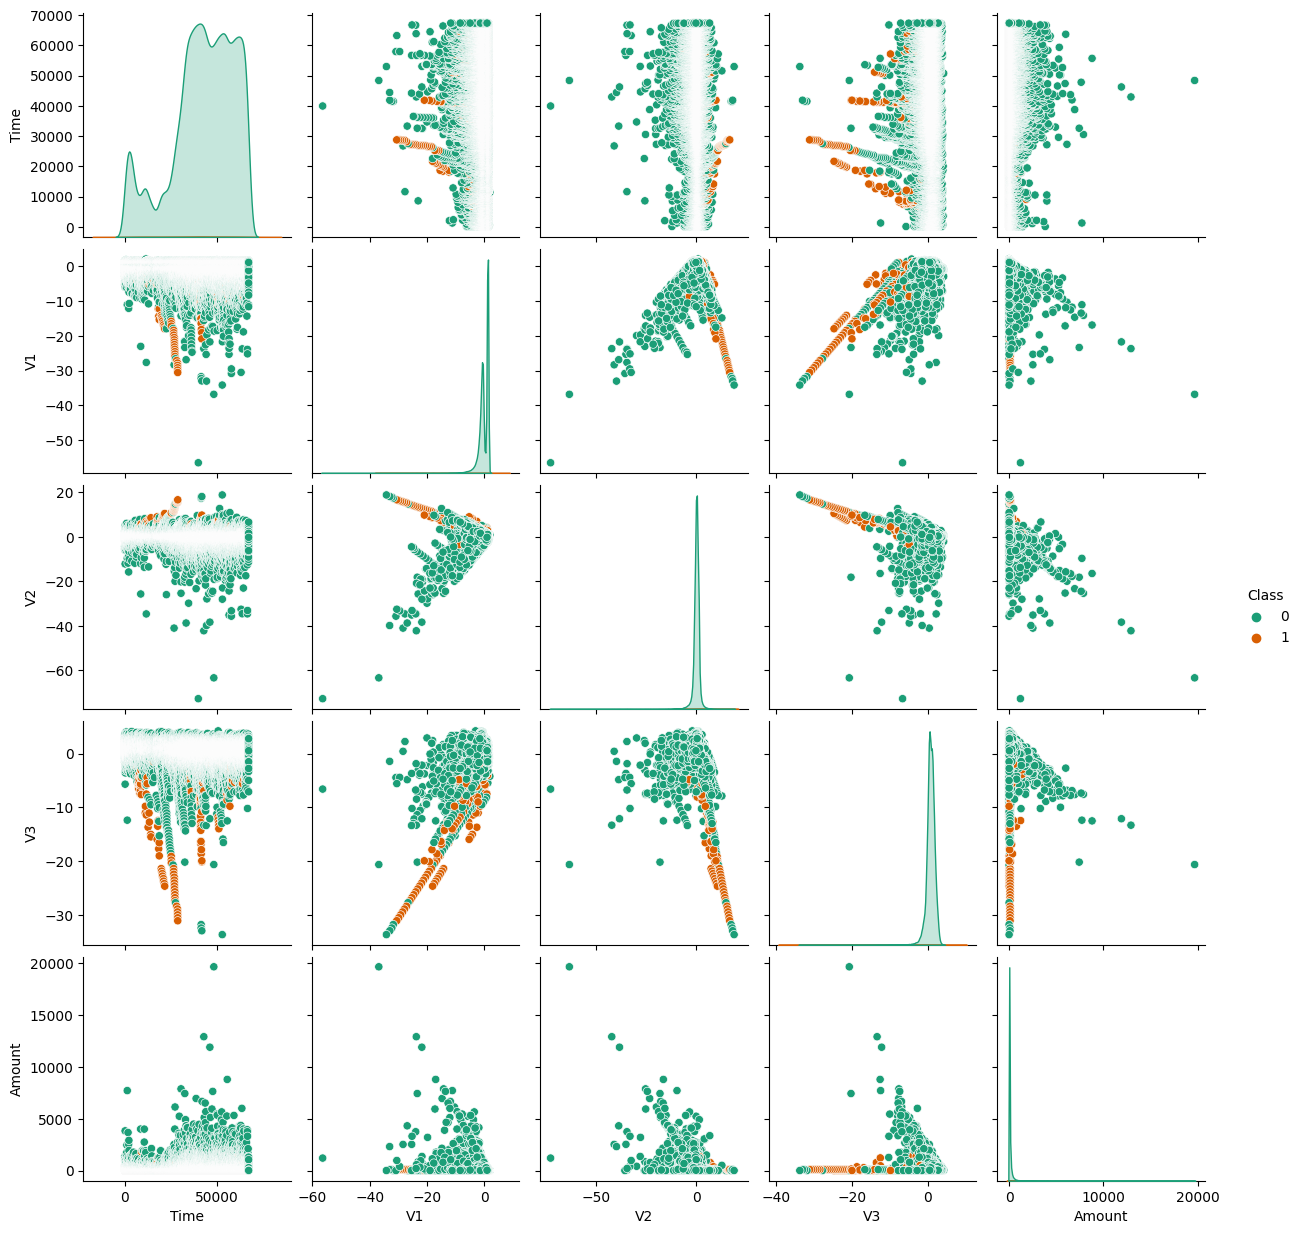

In [97]:
# Исследуем попарные зависимости части данных при помощи библиотеки seaborn
sns.pairplot(data.iloc[:100000, [0, 1, 2, 3, 29, 30]], hue='Class', palette='Dark2')

### 1.2. Сбалансированность классов

Верных транзакций: 284315;
Транзакций мошенников: 492.


<Axes: xlabel='Class', ylabel='Count'>

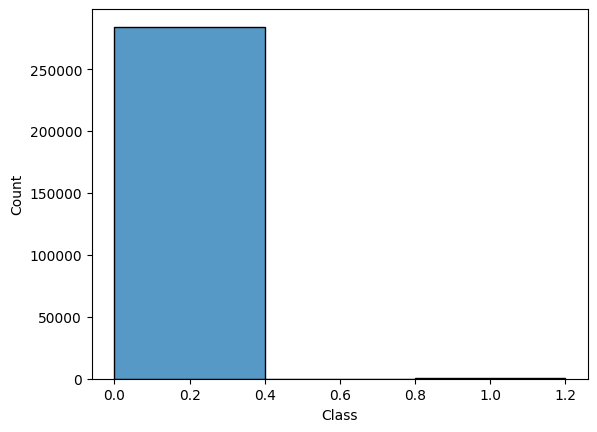

In [98]:
# Рассчитаем количество данных каждого класса

balance = data["Class"].value_counts().tolist()
print(f'Верных транзакций: {balance[0]};\nТранзакций мошенников: {balance[1]}.')

sns.histplot(data['Class'], binwidth=0.4)

Классы в базе данных несбалансированны - верных транзакций в 578 раз больше транзакций мошенников.

In [99]:
print('Верные транзакции:', round(data['Class'].value_counts()[0]/len(data) * 100, 2), '% базы данных')
print('Транзакции мошенников:', round(data['Class'].value_counts()[1]/len(data) * 100, 2), '% базы данных')

Верные транзакции: 99.83 % базы данных
Транзакции мошенников: 0.17 % базы данных


### 1.3. Статистические параметры признаков базы данных.

In [100]:
statistics_general = data.describe()
statistics_general

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


## 2. Разделение данных.

### 2.1. Разделение данных на тестовую и обучающую выборки в соотношении 20 % и 80 %.

In [101]:
X = data.drop('Class', axis=1)
y = data['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=21)

### 2.2. Анализ статистик подвыборок и генеральной выборки

In [102]:
statistics_train = X_train.describe()
statistics_test = X_test.describe()

statistics_train

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,...,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000
mean,94799.020676,0.000174,-0.001365,-0.003386,0.000190,-0.001483,-0.001034,0.000631,0.000670,0.001430,...,-0.000340,0.000432,0.000257,0.000195,-0.000562,0.000228,-0.000222,0.000013,0.000099,88.502064
std,47499.435070,1.971155,1.659895,1.523706,1.414941,1.388924,1.332236,1.246508,1.196834,1.099960,...,0.780951,0.739792,0.725920,0.618714,0.605352,0.521667,0.482660,0.404577,0.337103,253.374134
min,0.000000,-56.407510,-72.715728,-48.325589,-5.600607,-113.743307,-26.160506,-43.557242,-73.216718,-13.434066,...,-54.497720,-34.830382,-10.933144,-36.666000,-2.836627,-8.696627,-2.604551,-9.895244,-15.430084,0.000000
25%,54207.000000,-0.918277,-0.599558,-0.890923,-0.846347,-0.692015,-0.768632,-0.554119,-0.208743,-0.641823,...,-0.211975,-0.228295,-0.541723,-0.161636,-0.355073,-0.317322,-0.327169,-0.070836,-0.052863,5.550000
50%,84640.000000,0.023214,0.063697,0.178479,-0.020248,-0.053146,-0.274135,0.040140,0.022464,-0.049549,...,-0.062511,-0.029427,0.006495,-0.010720,0.040768,0.016919,-0.052481,0.001430,0.011195,22.000000
75%,139341.000000,1.316427,0.801844,1.025052,0.741196,0.612317,0.398258,0.570453,0.326785,0.597619,...,0.132858,0.186852,0.529203,0.147814,0.438815,0.351273,0.240843,0.090744,0.078089,77.050000
max,172792.000000,2.454930,22.057729,4.226108,16.875344,34.801666,73.301626,120.589494,20.007208,10.392889,...,39.420904,27.202839,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,25691.160000


In [103]:
statistics_test

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,...,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000,56962.000000
mean,94873.214389,-0.000696,0.005461,0.013544,-0.000759,0.005933,0.004136,-0.002523,-0.002681,-0.005718,...,0.001361,-0.001727,-0.001029,-0.000780,0.002247,-0.000913,0.000889,-0.000051,-0.000398,87.739847
std,47443.333461,1.908064,1.616511,1.486015,1.419584,1.344975,1.332416,1.198706,1.184385,1.093296,...,0.729451,0.713068,0.724833,0.646939,0.606827,0.519724,0.480492,0.399836,0.300371,236.658343
min,7.000000,-35.274010,-40.978852,-25.390229,-5.683171,-32.092129,-17.574835,-37.060311,-50.688419,-11.126624,...,-23.646890,-22.757540,-7.417140,-44.807735,-2.824849,-10.295397,-2.068561,-22.565679,-11.710896,0.000000
25%,54187.750000,-0.927959,-0.593680,-0.887022,-0.856560,-0.689161,-0.767067,-0.553645,-0.208363,-0.647741,...,-0.210603,-0.228883,-0.545206,-0.162599,-0.352707,-0.316404,-0.326273,-0.070866,-0.053396,5.710000
50%,84954.500000,-0.005976,0.073120,0.184959,-0.018467,-0.058519,-0.274496,0.039913,0.021839,-0.058020,...,-0.062382,-0.029645,0.008421,-0.012990,0.041594,0.015041,-0.051164,0.001114,0.011424,22.075000
75%,139248.000000,1.311509,0.811470,1.035517,0.751192,0.610188,0.400931,0.570343,0.330141,0.595253,...,0.133647,0.184584,0.525947,0.146984,0.442354,0.348289,0.241437,0.092101,0.079004,77.695000
max,172785.000000,2.422508,19.167239,9.382558,13.143668,24.363532,21.393069,34.303177,15.374630,15.594995,...,17.281859,16.666465,7.357255,18.946734,4.014444,5.852484,3.122747,8.932639,15.407019,7862.390000


In [104]:
print(f'Train: Class 0 - {y_train.value_counts().tolist()[0]}, Class 1 - {y_train.value_counts().tolist()[1]}')
print(f'Test: Class 0 - {y_test.value_counts().tolist()[0]}, Class 1 - {y_test.value_counts().tolist()[1]}')

Train: Class 0 - 227462, Class 1 - 383
Test: Class 0 - 56853, Class 1 - 109


## 3. Обучение моделей классификации

In [105]:
# Словарь с точностями моделей
accuracy = {}

### 3.1. Классификатор SVC с ядром в виде полинома 3 степени

In [106]:
# Создадим объект класса SVM с ядром в виде полинома 3 степени
classifier_SVM_poly3 = SVC(kernel='poly', degree=3)

# Обучение модели
classifier_SVM_poly3.fit(X_train, y_train)

# Прогноз
y_pred = classifier_SVM_poly3.predict(X_test)

# Расчет точности модели (доля верно классифицированных объектов)
accuracy['SVC_poly_3'] = accuracy_score(y_test, y_pred)

### 3.2. Классификатор SVC с ядром в виде полинома 5 степени

In [107]:
# Создадим объект класса SVM с ядром в виде полинома 5 степени
classifier_SVM_poly5 = SVC(kernel='poly', degree=5)

# Обучение модели
classifier_SVM_poly5.fit(X_train, y_train)

# Прогноз
y_pred = classifier_SVM_poly5.predict(X_test)

# Расчет точности модели (доля верно классифицированных объектов)
accuracy['SVC_poly_5'] = accuracy_score(y_test, y_pred)

### 3.3. Классификатор SVC с сигмовидным ядром

In [108]:
# Создадим объект класса SVM с сигмовидным ядром
classifier_SVM_sigmoid = SVC(kernel='sigmoid', gamma="auto")

# Обучение модели
classifier_SVM_sigmoid.fit(X_train, y_train)

# Прогноз
y_pred = classifier_SVM_sigmoid.predict(X_test)

# Расчет точности модели (доля верно классифицированных объектов)
accuracy['SVC_sigmoid'] = accuracy_score(y_test, y_pred)

### 3.4. Классификатор SVC с РБФ ядром и малым параметром `C`

In [109]:
# Создадим объект класса SVM с РБФ ядром
classifier_SVM_rbf = SVC(kernel='rbf', C=0.001)

# Обучение модели
classifier_SVM_rbf.fit(X_train, y_train)

# Прогноз
y_pred = classifier_SVM_rbf.predict(X_test)

# Расчет точности модели (доля верно классифицированных объектов)
accuracy['SVC_rbf'] = accuracy_score(y_test, y_pred)

### 3.5. Классификатор SVC с параметрами по умолчанию

In [110]:
# Создадим объект класса SVM с параметрами по умолчанию
classifier_SVM = SVC()

# Обучение модели
classifier_SVM.fit(X_train, y_train)

# Прогноз
y_pred = classifier_SVM.predict(X_test)

# Расчет точности модели (доля верно классифицированных объектов)
accuracy['SVC'] = accuracy_score(y_test, y_pred)

### 3.6. Анализ точностей моделей

In [111]:
accuracy_df = pd.DataFrame(accuracy, index=['accuracy'])
accuracy_df

,SVC_poly_3,SVC_poly_5,SVC_sigmoid,SVC_rbf,SVC
accuracy,0.998086,0.998086,0.998086,0.998086,0.998086


## 4. Вывод.

В результате обучения моделей классификации применение моделей к тестовой выборке дало одинаковый результат точности:
accuracy = 99.8 % .